# Finance with Tesorflow 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


## Introduction To Tensorflow

In [2]:
def compute_sin(a, b):
    a = tf.convert_to_tensor(a, name="a")
    b = tf.convert_to_tensor(b, name="b")
    c = tf.add(a, b, name="addition")
    d = tf.sin(c, name="sin")
    return d

compute_sin(1.0, 2.0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.14112>

In [4]:
g = tf.Graph()

with g.as_default():
    with tf.name_scope('main_graph'):
        c = compute_sin(1.0, 2.0)
    writer = tf.compat.v1.summary.FileWriter("logs", g)
    writer.close()

### tensorboard will pop up in another tab

## tensor and shapes

In [5]:
import numpy as np

In [7]:
x = np.array(2.0)
t = tf.constant(x)
print("shape of %s = %s\n" % (x, t.shape))

shape of 2.0 = ()



In [8]:
x = np.array([1,2,3,4,5])
t = tf.constant(x)
print("shape of %s = %s\n" % (x, t.shape))

shape of [1 2 3 4 5] = (5,)



In [17]:
x = tf.constant(np.array([[1], [2], [3], [4], [5]]))
print("x = %s\n" % x)
print("Shape x = %s\n" % x.shape)
print("rank x = %s\n" % tf.rank(x))
print("size x = %s\n" % tf.size(x))

x = tf.Tensor(
[[1]
 [2]
 [3]
 [4]
 [5]], shape=(5, 1), dtype=int64)

Shape x = (5, 1)

rank x = tf.Tensor(2, shape=(), dtype=int32)

size x = tf.Tensor(5, shape=(), dtype=int32)



In [16]:
x = tf.constant(np.array([[1,2,3,4,5]]))
print("x = %s\n" % x)
print("Shape x = %s\n" % x.shape)
print("rank x = %s\n" % tf.rank(x))
print("size x = %s\n" % tf.size(x))

x = tf.Tensor([[1 2 3 4 5]], shape=(1, 5), dtype=int64)

Shape x = (1, 5)

rank x = tf.Tensor(2, shape=(), dtype=int32)

size x = tf.Tensor(5, shape=(), dtype=int32)



In [15]:
x = tf.constant(np.arange(1, 13))
print("x = %s\n" % x)
print("Shape x = %s\n" % x.shape)
print("rank x = %s\n" % tf.rank(x))
print("size x = %s\n" % tf.size(x))

x = tf.Tensor([ 1  2  3  4  5  6  7  8  9 10 11 12], shape=(12,), dtype=int64)

Shape x = (12,)

rank x = tf.Tensor(1, shape=(), dtype=int32)

size x = tf.Tensor(12, shape=(), dtype=int32)



In [33]:
#@title quiz
# fill array!

x = np.array([ [[[0,0]], [[0,0]]] ])
t = tf.constant(x, name = "t")


if t.shape == [1, 2, 1, 2]:
  print ("rank is %s\n" % tf.rank(t))
  print ("Success!")
else:
  print ("Shape was %s. Try again"%t.shape)

rank is tf.Tensor(4, shape=(), dtype=int32)

Success!


In [32]:
x = tf.constant(np.array([[[0,0]], [[0,0]]]))
print(tf.rank(x))

tf.Tensor(3, shape=(), dtype=int32)


In [37]:
x = np.arange(1, 5)
print("orig %s\n" % x)
x_reshaped = np.reshape(x, [2,1,2,1])
print("reshaped %s" % x_reshaped)
t = tf.constant(x_reshaped)
print("Shape of x = %s" % t.shape)

orig [1 2 3 4]

reshaped [[[[1]
   [2]]]


 [[[3]
   [4]]]]
Shape of x = (2, 1, 2, 1)


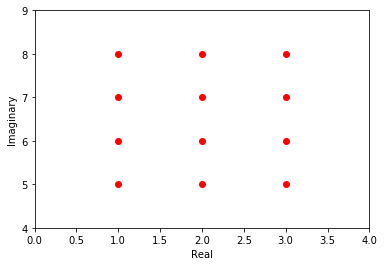

In [39]:
#@title Reshaping Quiz

import numpy as np
import matplotlib.pyplot as plt

def create_grid(x, y):
  """Creates a grid on the complex plane from x and y.

  Given a set of x and y coordinates as rank 1 tensors 
  of sizes n and m respectively, returns a complex tensor 
  of shape [n, m] containing points on the grid formed by
  intersection of horizontal and vertical lines rooted at
  those x and y values.
  
  Args:
    x: A float32 or float64 tensor of shape [n]
    y: A tensor of the same data type as x and shape [m].
    
  Returns:
    A complex tensor with shape [n, m].
  """
  X, Y = tf.meshgrid(x, y)
  return tf.complex(X, Y)



coords = tf.constant([1.0, 2.0, 3.0])
square_grid = create_grid(coords, coords)

def test():
  x_p = np.array([1.0, 2.0, 3.0])
  y_p = np.array([5.0, 6.0, 7.0, 8.0])
  grid = create_grid(tf.constant(x_p),  tf.constant(y_p))
  n_p = x_p.size * y_p.size
  x = np.reshape(np.real(grid), [n_p])
  y = np.reshape(np.imag(grid), [n_p])
  plt.plot(x, y, 'ro')
  plt.xlim((x_p.min() - 1.0, x_p.max() + 1.0))
  plt.ylim((y_p.min() - 1.0, y_p.max() + 1.0))
  plt.ylabel('Imaginary')
  plt.xlabel('Real')
  plt.show()

test()

## American Option Black Scholes

In [40]:
!pip install tf-quant-finance

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 1.0 MB 88 kB/s eta 0:00:0121
     |████████████████████████████████| 3.2 MB 132 kB/s eta 0:00:01


In [41]:
#@title Imports { display-mode: "form" }

import matplotlib.pyplot as plt
import numpy as np
import time

import pandas as pd
import seaborn as sns

import tensorflow as tf

# tff for Tensorflow Finance
import tf_quant_finance as tff 

# Shortcut alias
pde = tff.math.pde

from IPython.core.pylabtools import figsize
figsize(21, 14)  # better graph size for Colab  

import warnings
warnings.filterwarnings("ignore",
                        category=FutureWarning)  # suppress printing warnings


### Setup American Option pricer
   American option price $V(x, t)$ of an option with spot price $x$ at time $t$
   under Black-Scholes model satisfies the following PDE
   $$V_{t} + \frac{\sigma^2}{2}  x^2  V_{xx} + r  x  V_{x}
 - r  V(t, x) = 0.$$
  Tensorflow Quant Finance library provides tools for solving Parabolic PDE's
  of the form  
  $$V_{t} + \frac{a(t, x)}{2}  V_{xx} + b(t, x) V_{x} - c(t, x)  V = 0$$

  Henceforth,
  $a(t, x)$, $b(t, x)$, and $c(t, x)$ are referred to as quadratic, linear and
  shift coefficients, respectively. We describe in details how to write a
  custom pricer that is both batchable (i.e., multiple equations can be solved
  simultaneously) and compatible with an NVIDIA GPU. 